# Zadanie
### Autor: Michał Karp
Bracie, wytrenuj sobie segmentację na dostarczonym datasetcie. Wykorzystaj pretrenowany ViT.

# Ograniczenia

- GPU Colab T4
- max 20 min na gpu (bez pobierania danych)
- rozwiązanie będzie testowanie w środowisku bez dostępu do internetu
- nie możesz trenować na zbiorze walidacyjnym ale możesz go użyć do early stopping i innych tego typu technik

# Ocenianie
Metryką jest Dice coefficient. Wzór na Dice coefficient to:

$$
\text{Dice} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$$

Gdzie:

- TP – True Positives (prawidłowo przewidziane piksele obiektu)

- FP – False Positives (piksele tła przewidziane jako obiekt)

- FN – False Negatives (piksele obiektu przewidziane jako tło).

Jeśli Dice cooficent jest poniżej 0.7, otrzymasz 0 punktów. Jeśli powyżej 0.98, otrzymasz 100 punktów. Pomiędzy tymi wartościami wynik rośnie liniowo.

Inne popularne metryki to F1 score, accuracy itp, ale my posłużymy się tą.

# Kod startowy

In [1]:
##### NIE ZMIENIAJ TEJ KOMÓRKI #####

import kagglehub
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

In [2]:
##### NIE ZMIENIAJ TEJ KOMÓRKI #####

path = kagglehub.dataset_download("hngngn/portrait-segmentation-128x128")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/portrait-segmentation-128x128


Train set: 18698 przykładów  •  Val set: 3740 przykładów


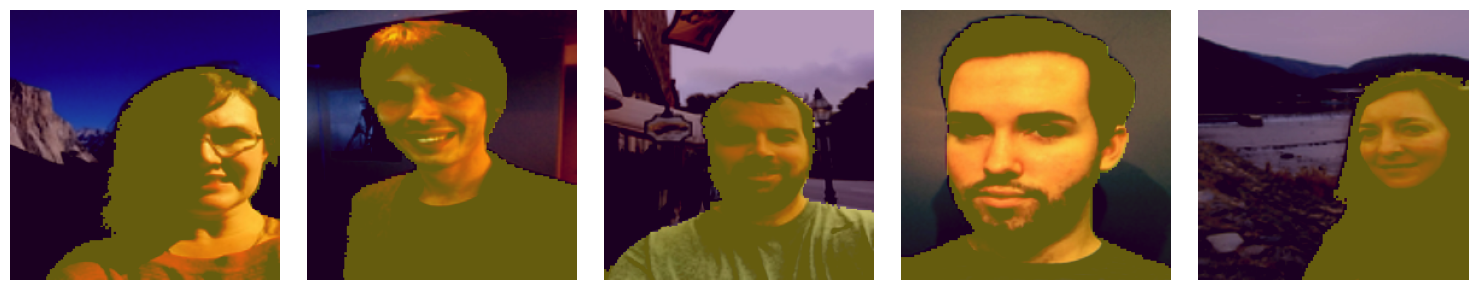

In [3]:
##### NIE ZMIENIAJ TEJ KOMÓRKI (no ok możesz dostosować batch size) #####

BASE_DIR = Path(path)

TRAIN_IMG_DIR = BASE_DIR / "xtrain"
TRAIN_MSK_DIR = BASE_DIR / "ytrain"

VAL_IMG_DIR = BASE_DIR / "xtest"
VAL_MSK_DIR = BASE_DIR / "ytest"

to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

mask_to_tensor = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.ToTensor(),
])

class PortraitSegDataset(Dataset):
    def __init__(self, img_dir, msk_dir, img_transform=None, msk_transform=None):
        self.img_dir = Path(img_dir)
        self.msk_dir = Path(msk_dir)
        self.img_transform = img_transform
        self.msk_transform = msk_transform

        self.names = sorted({p.name for p in self.img_dir.iterdir() if p.suffix.lower() == ".png"})

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img = Image.open(self.img_dir / name).convert("RGB")
        msk = Image.open(self.msk_dir / name).convert("L")

        if self.img_transform:
            img = self.img_transform(img)

        if self.msk_transform:
            msk = self.msk_transform(msk)

        return img, msk

train_ds = PortraitSegDataset(TRAIN_IMG_DIR, TRAIN_MSK_DIR, img_transform=to_tensor, msk_transform=mask_to_tensor)
val_ds = PortraitSegDataset(VAL_IMG_DIR, VAL_MSK_DIR, img_transform=to_tensor, msk_transform=mask_to_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print(f"Train set: {len(train_ds)} przykładów  •  Val set: {len(val_ds)} przykładów")

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img, msk = train_ds[i]
    ax = axes[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.imshow(msk.squeeze(), alpha=0.4)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [4]:
##### NIE ZMIENIAJ TEJ KOMÓRKI #####

model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Rozwiązanie
W tej sekcji wytrenuj model i umieść rozwiązanie.

In [5]:
from statistics import mean
from itertools import chain
from torch import nn

seg = nn.Sequential(
    nn.ConvTranspose2d(768, 256, 2, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(256, 64, 2, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 2, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 1, 2, stride=2)
).cuda()

optimizer = torch.optim.Adam(chain(model.parameters(), seg.parameters()), lr=1e-3)
criterion = torch.nn.functional.binary_cross_entropy_with_logits

NUM_EPOCHS = 1
N_LOG_STEPS = 10

for epoch in range(NUM_EPOCHS):
  losses = []
  for step, batch in enumerate(train_loader):
    optimizer.zero_grad()
    X, y = batch[0].cuda(), batch[1].cuda()

    tokens = model(X, output_hidden_states=True).last_hidden_state[:,1:,:]
    fmap = tokens.transpose(1,2).reshape(-1, 768, 14, 14)
    pred = seg(fmap)

    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (step+1)%N_LOG_STEPS == 0:
      print(f"Epoch {epoch+1}/{NUM_EPOCHS}; Step {step + 1}/{len(train_loader)}; Train loss: {mean(losses)}")
      losses = []

Epoch 1/1; Step 10/584; Train loss: 0.6607862114906311
Epoch 1/1; Step 20/584; Train loss: 0.5581186383962631
Epoch 1/1; Step 30/584; Train loss: 0.5684904515743255
Epoch 1/1; Step 40/584; Train loss: 0.5494363188743592
Epoch 1/1; Step 50/584; Train loss: 0.5136604756116867
Epoch 1/1; Step 60/584; Train loss: 0.41749400794506075
Epoch 1/1; Step 70/584; Train loss: 0.336591911315918
Epoch 1/1; Step 80/584; Train loss: 0.25144166946411134
Epoch 1/1; Step 90/584; Train loss: 0.21073949635028838
Epoch 1/1; Step 100/584; Train loss: 0.1900445520877838
Epoch 1/1; Step 110/584; Train loss: 0.15139744952321052
Epoch 1/1; Step 120/584; Train loss: 0.18563908338546753
Epoch 1/1; Step 130/584; Train loss: 0.15391672551631927
Epoch 1/1; Step 140/584; Train loss: 0.15267716497182846
Epoch 1/1; Step 150/584; Train loss: 0.14274163022637368
Epoch 1/1; Step 160/584; Train loss: 0.14601261243224145
Epoch 1/1; Step 170/584; Train loss: 0.14173666313290595
Epoch 1/1; Step 180/584; Train loss: 0.147441834

In [6]:
@torch.no_grad()
def segment_image(valid_dataset: list):
  model.eval()
  seg.eval()
  masks = []
  dl = DataLoader(valid_dataset, batch_size=64, shuffle=False)

  for X in dl:
    tokens = model(X.cuda(), output_hidden_states=True).last_hidden_state[:,1:,:]
    fmap = tokens.transpose(1,2).reshape(-1, 768, 14, 14)
    pred = seg(fmap)
    masks.append(pred)

  return torch.cat(masks, dim=0).cpu() > 0

# Wynik

In [7]:
def dice_coefficient(targets, predictions):
    dice_scores = []
    for target, pred in zip(targets, predictions):
        intersection = (target & pred).sum().float()
        union = target.sum().float() + pred.sum().float()
        dice = (2. * intersection) / (union + 1e-8)
        dice_scores.append(dice)

    return torch.mean(torch.stack(dice_scores)).item()

In [8]:
def scale_dice(dice):
    if dice < 0.7:
        return 0.0
    elif dice > 0.98:
        return 100.0
    else:
        return 100 * (dice - 0.7) / (0.98 - 0.7)

In [9]:
result = dice_coefficient(
    list(map(lambda X: X[1].bool(), val_ds)),
    segment_image(list(map(lambda X: X[0], val_ds)))
)

print(f"Dice cooficent:", result)
print(f"Score:", scale_dice(result))

Dice cooficent: 0.9795815348625183
Score: 99.85054816518512
